In [1]:
import numpy as np
import h5py

import json

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm

In [2]:
import sys
sys.path.insert(0, "../hat_utils/")

In [3]:
sig_file = "/gpfs/slac/atlas/fs1/d/rafaeltl/public/boostedHbb/Inputs4Trainings/2019Aug4/newvralg_allVR/HH_weight.h5"
bkg_file = "/gpfs/slac/atlas/fs1/d/rafaeltl/public/boostedHbb/Inputs4Trainings/2019Aug4/newvralg_allVR/QCD_all.h5"

In [4]:
sig = pd.read_hdf(sig_file, "fatjets")
print(sig.shape)

(2000000, 247)


In [5]:
bkg = pd.read_hdf(bkg_file, "fatjets")
print(bkg.shape)

(2100000, 246)


In [6]:
train_vars = [
    "pt", "eta", 
    "VR_1_vr_dl1r_discriminant_pcbt", "VR_2_vr_dl1r_discriminant_pcbt", "VR_3_vr_dl1r_discriminant_pcbt",
    "VR_1_deta", "VR_2_deta", "VR_3_deta", 
    "VR_1_dphi", "VR_2_dphi", "VR_3_dphi", 
    "VR_2_dr_VR1", "VR_3_dr_VR1"
]

for tv in train_vars:
    bkg.loc[ bkg[tv] < -80, tv ] = 0
    sig.loc[ sig[tv] < -80, tv ] = 0

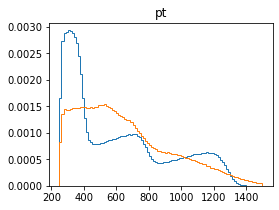

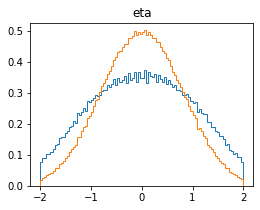

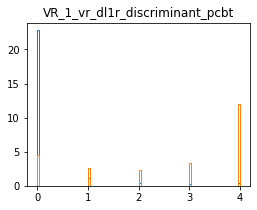

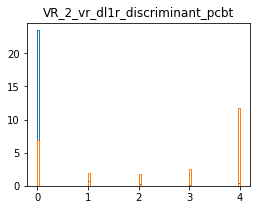

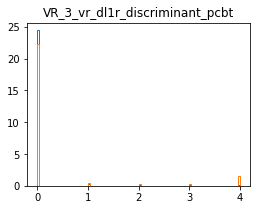

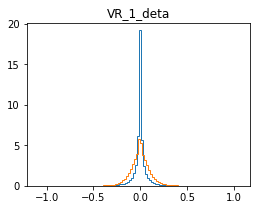

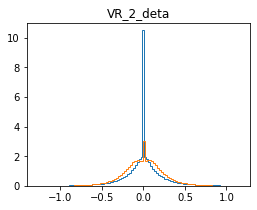

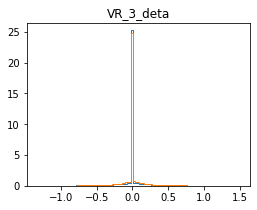

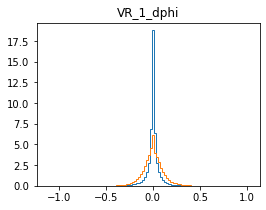

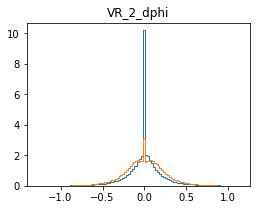

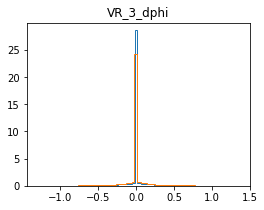

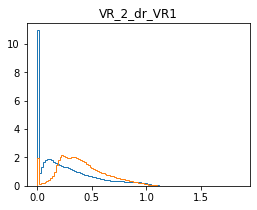

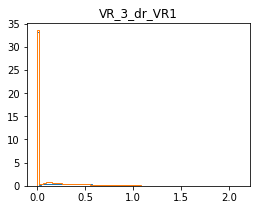

In [7]:
for kk in train_vars:
    plt.figure(figsize=(4,3))
    plt.hist(bkg[kk], density=1, histtype='step', bins=100)
    plt.hist(sig[kk], density=1, histtype='step', bins=100)
    plt.title(kk)
    plt.show()

In [8]:
bkg_train = bkg[train_vars]
sig_train = sig[train_vars]

In [9]:
bkg["transf_mass"] = np.log( bkg["mass"] )
sig["transf_mass"] = np.log( sig["mass"] )

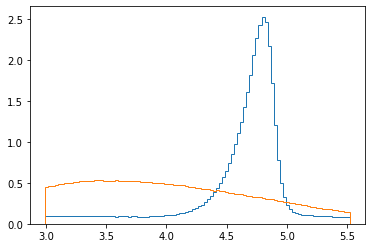

In [11]:
plt.figure()
plt.hist( sig["transf_mass"], density=1, bins=100, histtype='step' )
plt.hist( bkg["transf_mass"], density=1, bins=100, histtype='step' )
plt.show()

In [12]:
X_all = pd.concat([sig_train, bkg_train]).values
Y_all = []
for _df, ID in [ ( sig_train, 1), (bkg_train, 0) ]:
    Y_all.extend( [ID] * _df.shape[0] )
Y_all = np.array(Y_all)

In [13]:
W_all = pd.concat( [ sig['qcdWeight'], bkg['mcEventWeight'] ], ignore_index=True ).values

In [14]:
Z_all = pd.concat( [ sig['transf_mass'], bkg['transf_mass'] ], ignore_index=True ).values

In [15]:
print(Z_all.shape)

(4100000,)


In [16]:
from sklearn.preprocessing import StandardScaler
tf = StandardScaler()
X_all = tf.fit_transform(X_all)
tf_mass = StandardScaler()
tf_mass.fit(Z_all[Y_all==0].reshape(-1,1))
Z_all = tf_mass.transform( Z_all.reshape(-1,1))

In [17]:
print(Z_all.shape, Z_all.flatten().shape)

(4100000, 1) (4100000,)


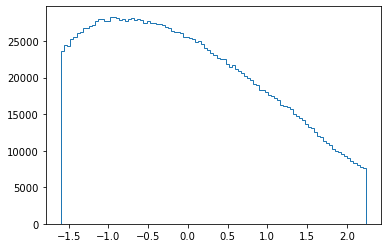

In [18]:
plt.figure()
plt.hist(Z_all[Y_all==0].flatten(), bins=100, histtype='step')
plt.show()

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
ix = range(X_all.shape[0])
X_train, X_test, Y_train, Y_test, W_train, W_test, Z_train, Z_test, ix_train, ix_test = train_test_split(X_all, Y_all, W_all, Z_all, ix, train_size=0.6)

In [21]:
print("xtrain", X_train.shape)

xtrain (2460000, 13)


In [221]:
import models

In [222]:
import importlib
importlib.reload(models)

<module 'models' from '../hat_utils/models.py'>

In [223]:
my_hat = models.hat_model("test_hat", "/gpfs/slac/atlas/fs1/u/rafaeltl/HbbTagging/29Octo2019/HAT/notebooks/test_models/")

In [224]:
my_hat.create_discriminant( len(train_vars) )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 13)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 20)                280       
_________________________________________________________________
activation_26 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 21        
_________________________________________________________________
lambda_22 (Lambda)           (None, 1)                 0         
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________
...Model compiled!


In [ ]:
hist_disc = my_hat.pretrain_discriminant( X_train, Y_train, W_train )

Train on 1968000 samples, validate on 492000 samples
Epoch 1/20
1968000/1968000 [==============================] - 13s 7us/step - loss: 0.6438 - val_loss: 0.2692

Epoch 00001: val_loss improved from inf to 0.26918, saving model to /gpfs/slac/atlas/fs1/u/rafaeltl/HbbTagging/29Octo2019/HAT/notebooks/test_models//test_hat_discriminant_pretraining_progress.h5
Epoch 2/20
1968000/1968000 [==============================] - 12s 6us/step - loss: 0.2732 - val_loss: 0.2803

Epoch 00002: val_loss did not improve from 0.26918
Epoch 3/20
1968000/1968000 [==============================] - 13s 6us/step - loss: 0.2519 - val_loss: 0.2337

Epoch 00003: val_loss improved from 0.26918 to 0.23374, saving model to /gpfs/slac/atlas/fs1/u/rafaeltl/HbbTagging/29Octo2019/HAT/notebooks/test_models//test_hat_discriminant_pretraining_progress.h5
Epoch 4/20
1968000/1968000 [==============================] - 12s 6us/step - loss: 0.2825 - val_loss: 0.2220

Epoch 00004: val_loss improved from 0.23374 to 0.22199, saving

In [201]:
pretrained_yhat = my_hat.discriminant.predict(X_all, verbose=True, batch_size=1028)

4100000/4100000 [==============================] - 10s 2us/step


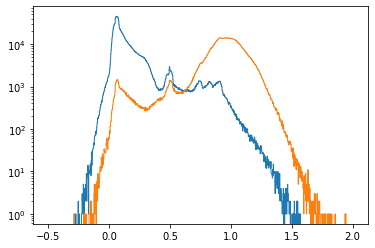

In [202]:
plt.figure()
plt.hist( pretrained_yhat[Y_all == 0], bins=1000, range=(-0.5, 2), histtype='step' )
ns, bs, _ = plt.hist( pretrained_yhat[Y_all == 1], bins=1000, range=(-0.5, 2), histtype='step' )
plt.yscale('log')
plt.show()

In [203]:
wps = {'0.4':0, '0.5': 0, '0.6': 0}
for wp in wps:
    for ib in range(0, len(bs)-1):
        eff = ns[ib:].sum()/ns.sum()
        if eff < float(wp):
            print(wp, eff, bs[ib])
            wps[wp] = bs[ib]
            break

0.4 0.3993226996613498 0.9925
0.5 0.49660074830037415 0.9575
0.6 0.5930912965456483 0.9225


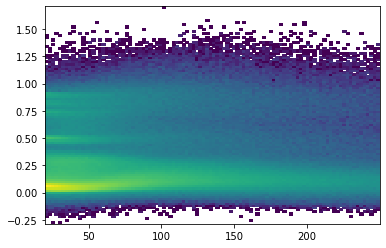

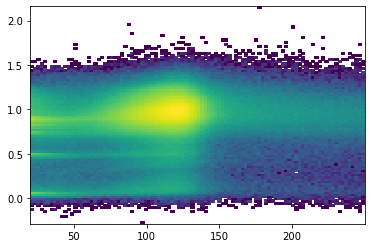

In [204]:
plt.figure()
plt.hist2d(bkg["mass"], pretrained_yhat[Y_all == 0].flatten(), bins=(100,100), norm=LogNorm())
plt.show()
plt.figure()
plt.hist2d(sig["mass"], pretrained_yhat[Y_all == 1].flatten(), bins=(100,100), norm=LogNorm())
plt.show()

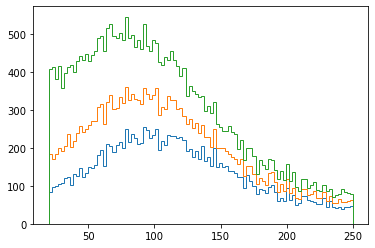

In [205]:
plt.figure()
plt.hist( bkg[ (pretrained_yhat[Y_all == 0] > wps['0.4']) & (pretrained_yhat[Y_all == 0] < 5.5) ]["mass"], bins=100, histtype='step', density=0)
plt.hist( bkg[ (pretrained_yhat[Y_all == 0] > wps['0.5']) & (pretrained_yhat[Y_all == 0] < 5.5) ]["mass"], bins=100, histtype='step', density=0)
plt.hist( bkg[ (pretrained_yhat[Y_all == 0] > wps['0.6']) & (pretrained_yhat[Y_all == 0] < 5.5) ]["mass"], bins=100, histtype='step', density=0)
plt.show()

In [206]:
my_hat.create_adversarial(Lambda=1.0)

Compiling model...


In [207]:
hist_disc = my_hat.pretrain_adversarial( X_train[Y_train==0], Z_train[Y_train==0], W_train[Y_train==0] )

Epoch 1/20
1260447/1260447 [==============================] - 9s 7us/step - loss: 0.1226
Epoch 2/20
1260447/1260447 [==============================] - 7s 6us/step - loss: 0.0730
Epoch 3/20
1260447/1260447 [==============================] - 8s 7us/step - loss: 0.0687
Epoch 4/20
1260447/1260447 [==============================] - 8s 7us/step - loss: 0.0653
Epoch 5/20
1260447/1260447 [==============================] - 8s 6us/step - loss: 0.0631
Epoch 6/20
1260447/1260447 [==============================] - 8s 6us/step - loss: 0.0622
Epoch 7/20
1260447/1260447 [==============================] - 8s 6us/step - loss: 0.0615
Epoch 8/20
1260447/1260447 [==============================] - 7s 6us/step - loss: 0.0609
Epoch 9/20
1260447/1260447 [==============================] - 6s 4us/step - loss: 0.0602
Epoch 10/20
1260447/1260447 [==============================] - 6s 5us/step - loss: 0.0596
Epoch 11/20
1260447/1260447 [==============================] - 7s 6us/step - loss: 0.0592
Epoch 12/20
1260447

In [208]:
my_hat.make_combined_model(Lambda=1.0)

In [209]:
wtrain_list = (W_train,W_train)
# wtrain_list = list(wtrain_list)

In [220]:
my_hat.adversarial_training(X_train, Y_train, Z_train, 1.0, wtrain=W_train , rounds=range(50), batch_size=1024)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()